# CH10 계절형 ARIMA

In [ ]:
install.packages("sarima")
library(sarima)

also installing the dependencies ‘PolynomF’, ‘Formula’, ‘lagged’, ‘ltsa’




In [2]:
options(repr.plot.width = 15, repr.plot.height = 8)

## 10.2

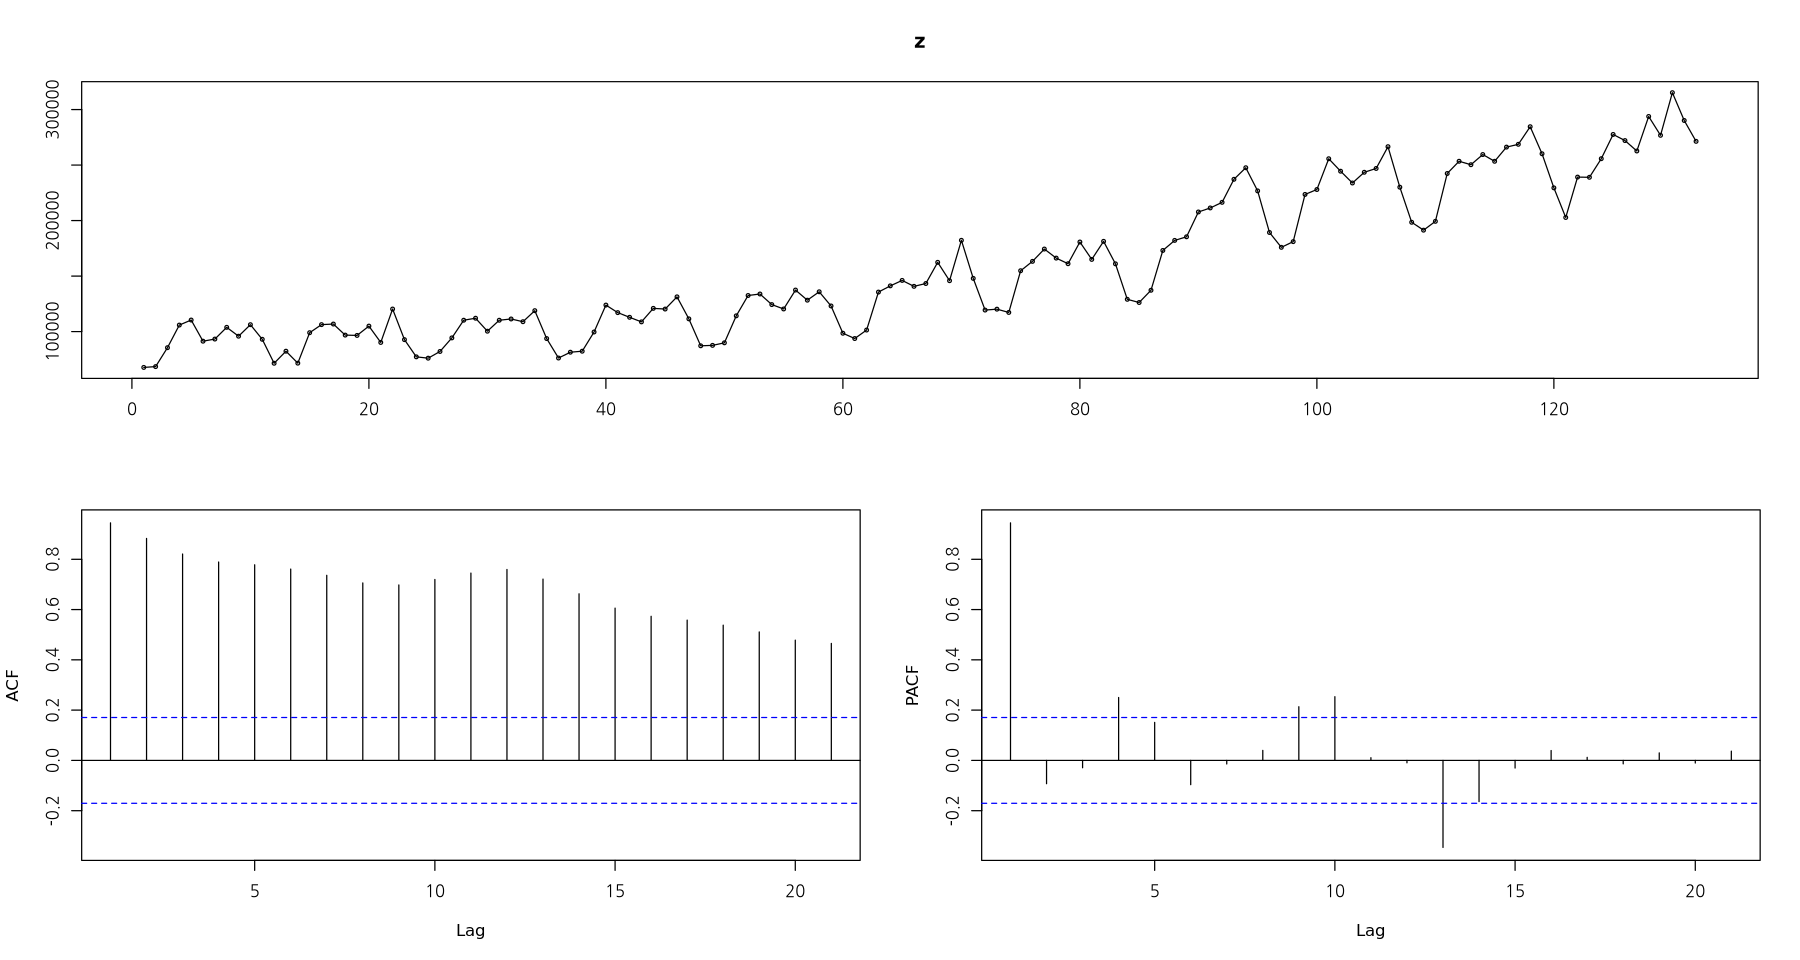

In [3]:
z = scan("/root/TS2024/data/Time Series Data/tourist.txt")
forecast::tsdisplay(z)

> 전형적인 이분산 데이터

`-` 분산 안정화 : 변수 변환

In [6]:
log_z = log(z)
sqrt_z = sqrt(z)
boxcox_z = forecast::BoxCox(z,lambda= forecast::BoxCox.lambda(z))

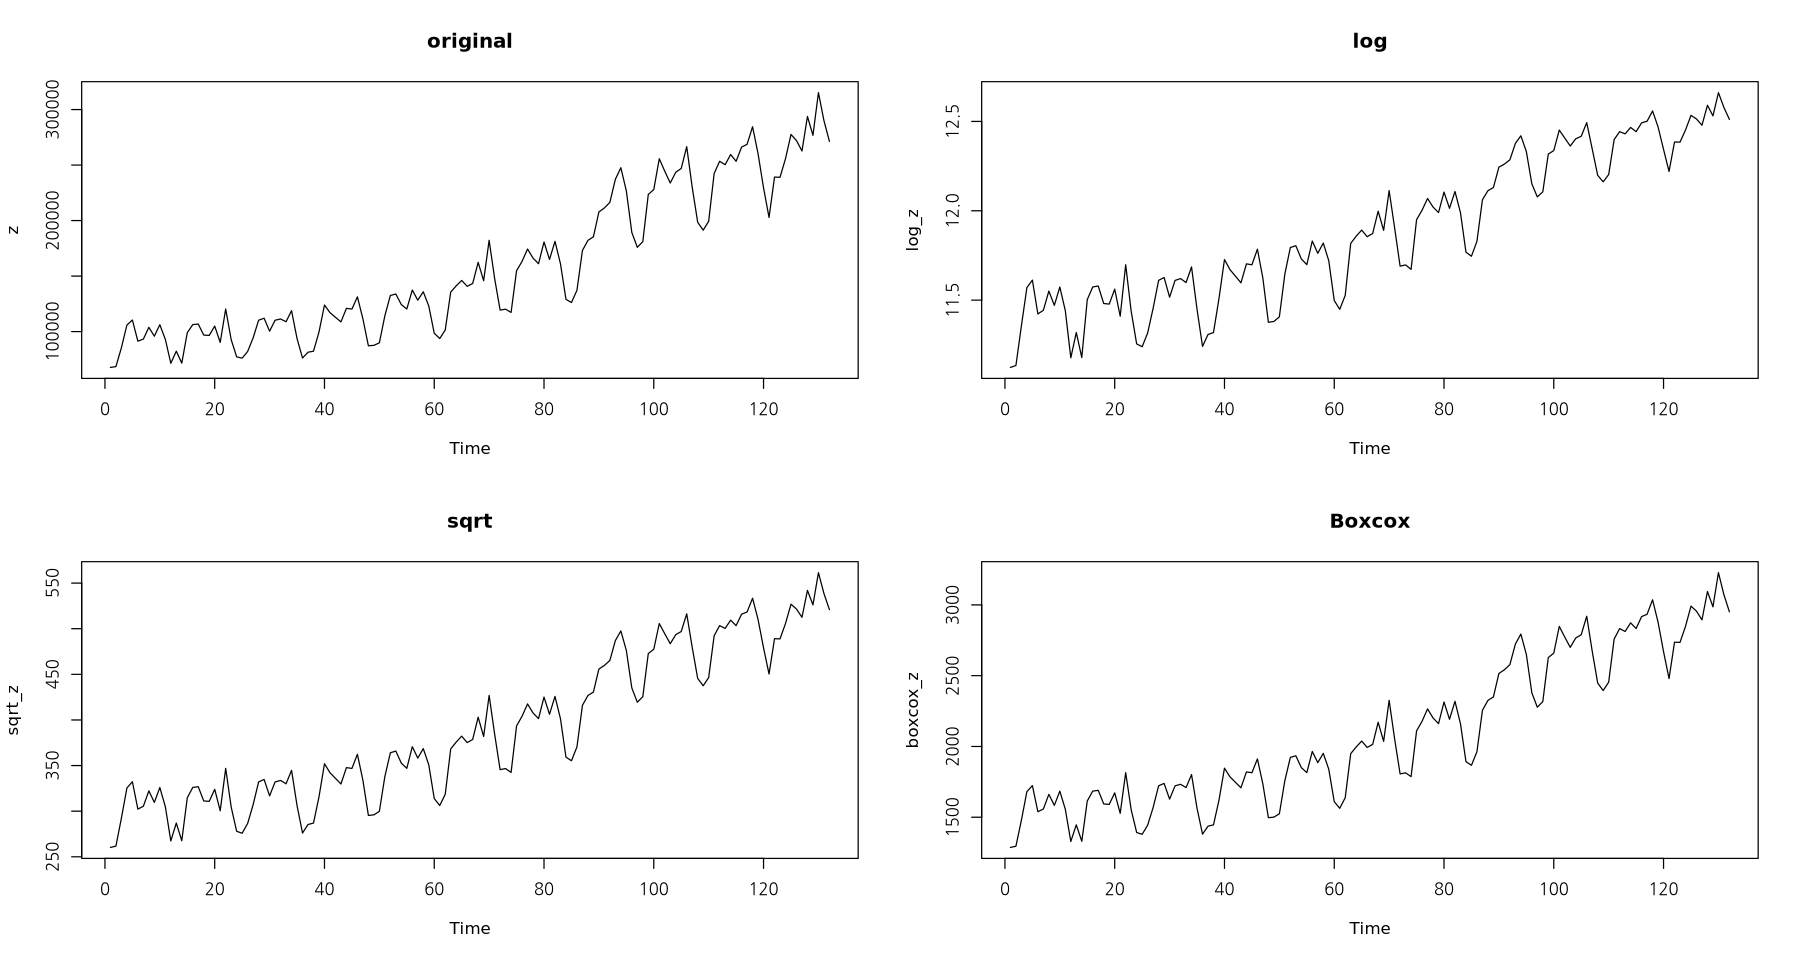

In [7]:
par(mfrow=c(2,2))
plot.ts(z, main = "original")
plot.ts(log_z, main = 'log')
plot.ts(sqrt_z, main = 'sqrt')
plot.ts(boxcox_z, main = 'Boxcox')

> 로그 변환을 하니까, 뒤를 오히려 더 많이 눌러줌
>
> sqrt / box-cox는 거의 비슷하니까 -> sqrt 변환 할거라고 해도 됨. 하지만 이번에는 역변환 보여줄려고 box-cox transform을 함.

In [8]:
t = 1:length(z)
lmtest::bptest(lm(z~t)) #H0 : 등분산이다
lmtest::bptest(lm(log_z~t))
lmtest::bptest(lm(sqrt_z~t))
lmtest::bptest(lm(boxcox_z~t))


	studentized Breusch-Pagan test

data:  lm(z ~ t)
BP = 1.574, df = 1, p-value = 0.2096



	studentized Breusch-Pagan test

data:  lm(log_z ~ t)
BP = 5.4539, df = 1, p-value = 0.01953



	studentized Breusch-Pagan test

data:  lm(sqrt_z ~ t)
BP = 0.26821, df = 1, p-value = 0.6045



	studentized Breusch-Pagan test

data:  lm(boxcox_z ~ t)
BP = 0.026422, df = 1, p-value = 0.8709


> 등분산 검정. 그냥 하고 싶은 사람만 합시다.
>
> 이분산성이 있으므로, Box-Cox 변환을 수행하였으나, 제곱근 변환과 거의 차이가 없었으므로 제곱근 변환을 하도록 하겠다. 라고 쓰면 됨.

`-` $\lambda = 0.597$을 이용한 Boxcox 변환 수행

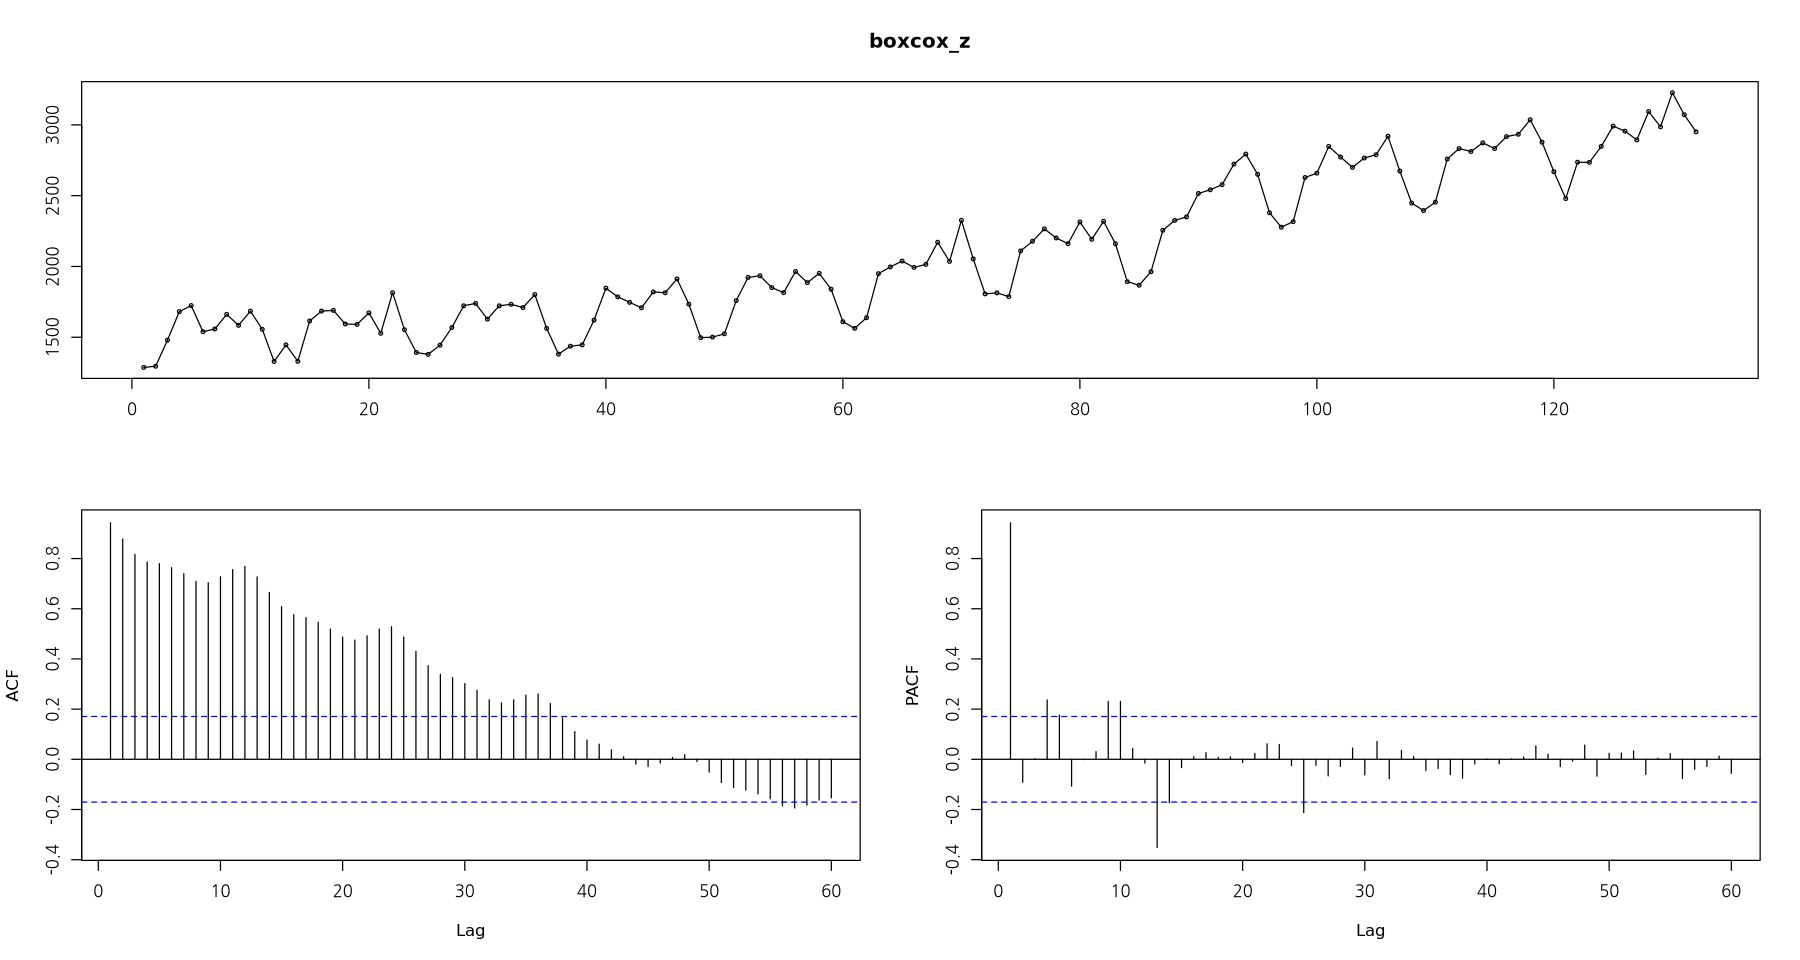

In [9]:
forecast::tsdisplay(boxcox_z, lag.max = 60)

> ACF가 천천히 감소하나, 12의 배수마다 높아짐 -> 계절차분 진행

`-` 계절주기가 12인 계절차분

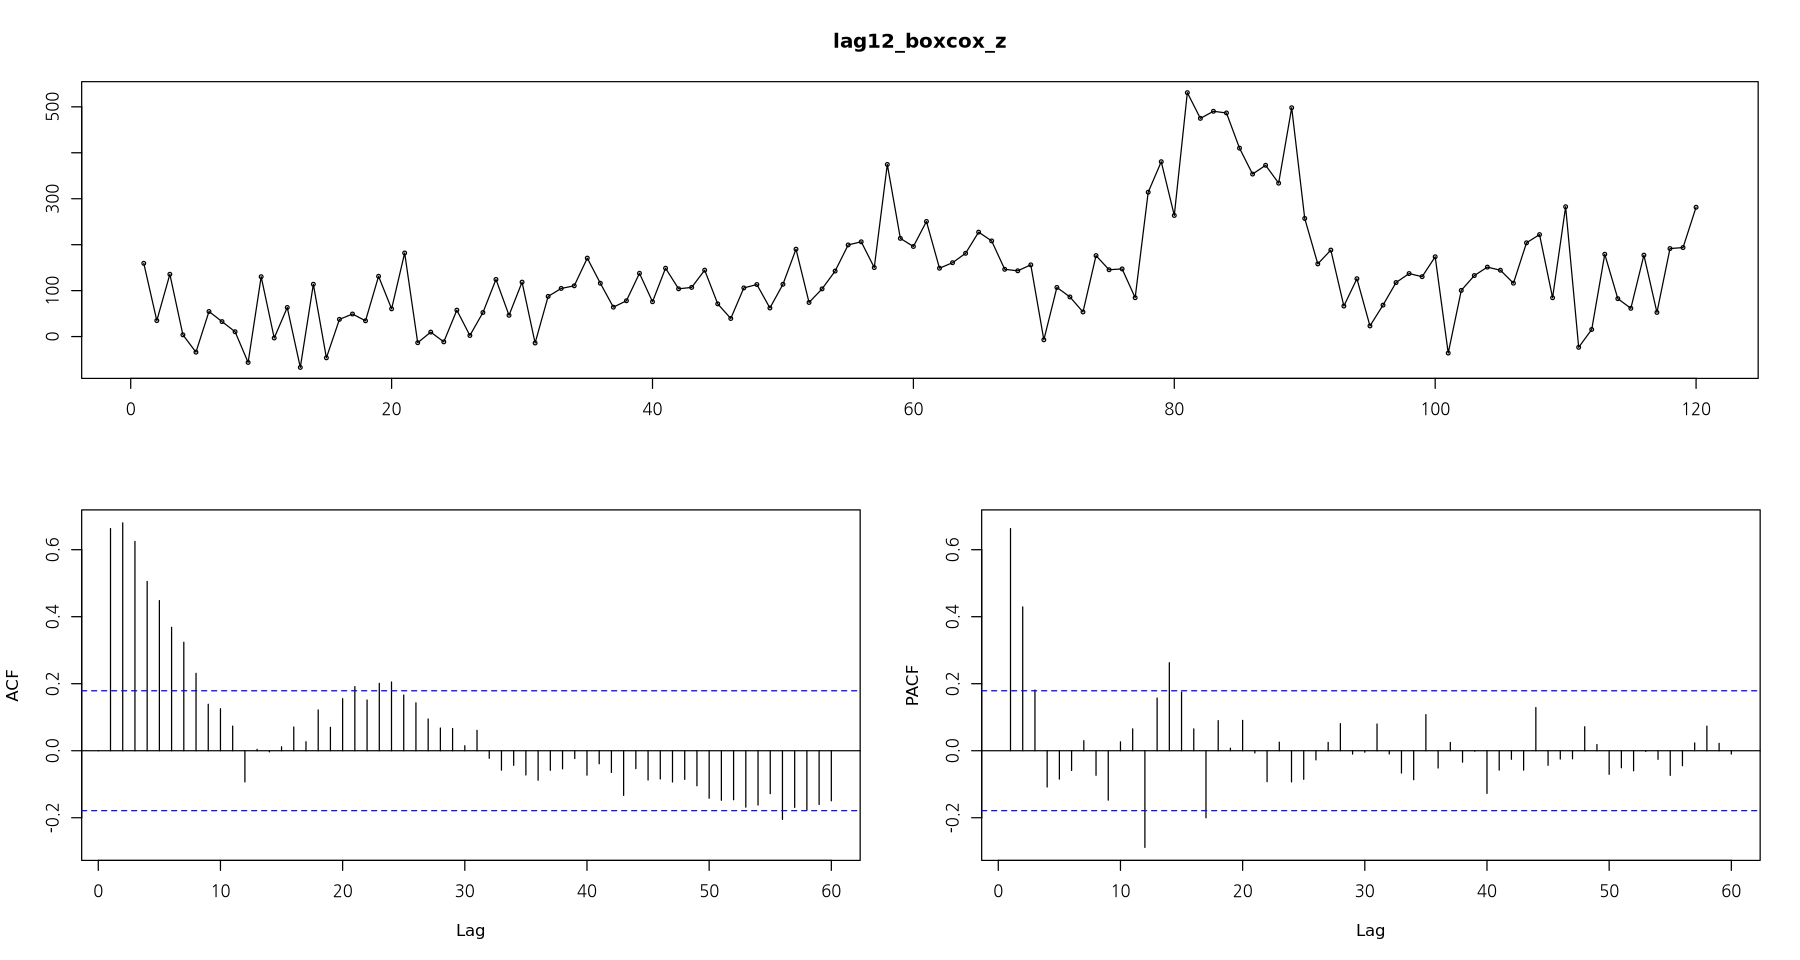

In [10]:
lag12_boxcox_z = diff(boxcox_z, lag=12)
forecast::tsdisplay(lag12_boxcox_z, lag.max=60)

> 계절추세는 사라짐.
>
> ACF가 천천히 감소...? 확률적 추세가 하나 더 있는 것 같음.

`-` 단위근 검정

In [11]:
##단위근 검정 : H0 : 단위근이 있다.
fUnitRoots::adfTest(lag12_boxcox_z, lags = 1, type = "c")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -2.6696
  P VALUE:
    0.08535 

Description:
 Wed Nov 27 18:02:51 2024 by user: 

> 단위근 검정 결과 귀무가설 기각 불가 -> 차분을 하기로 함.

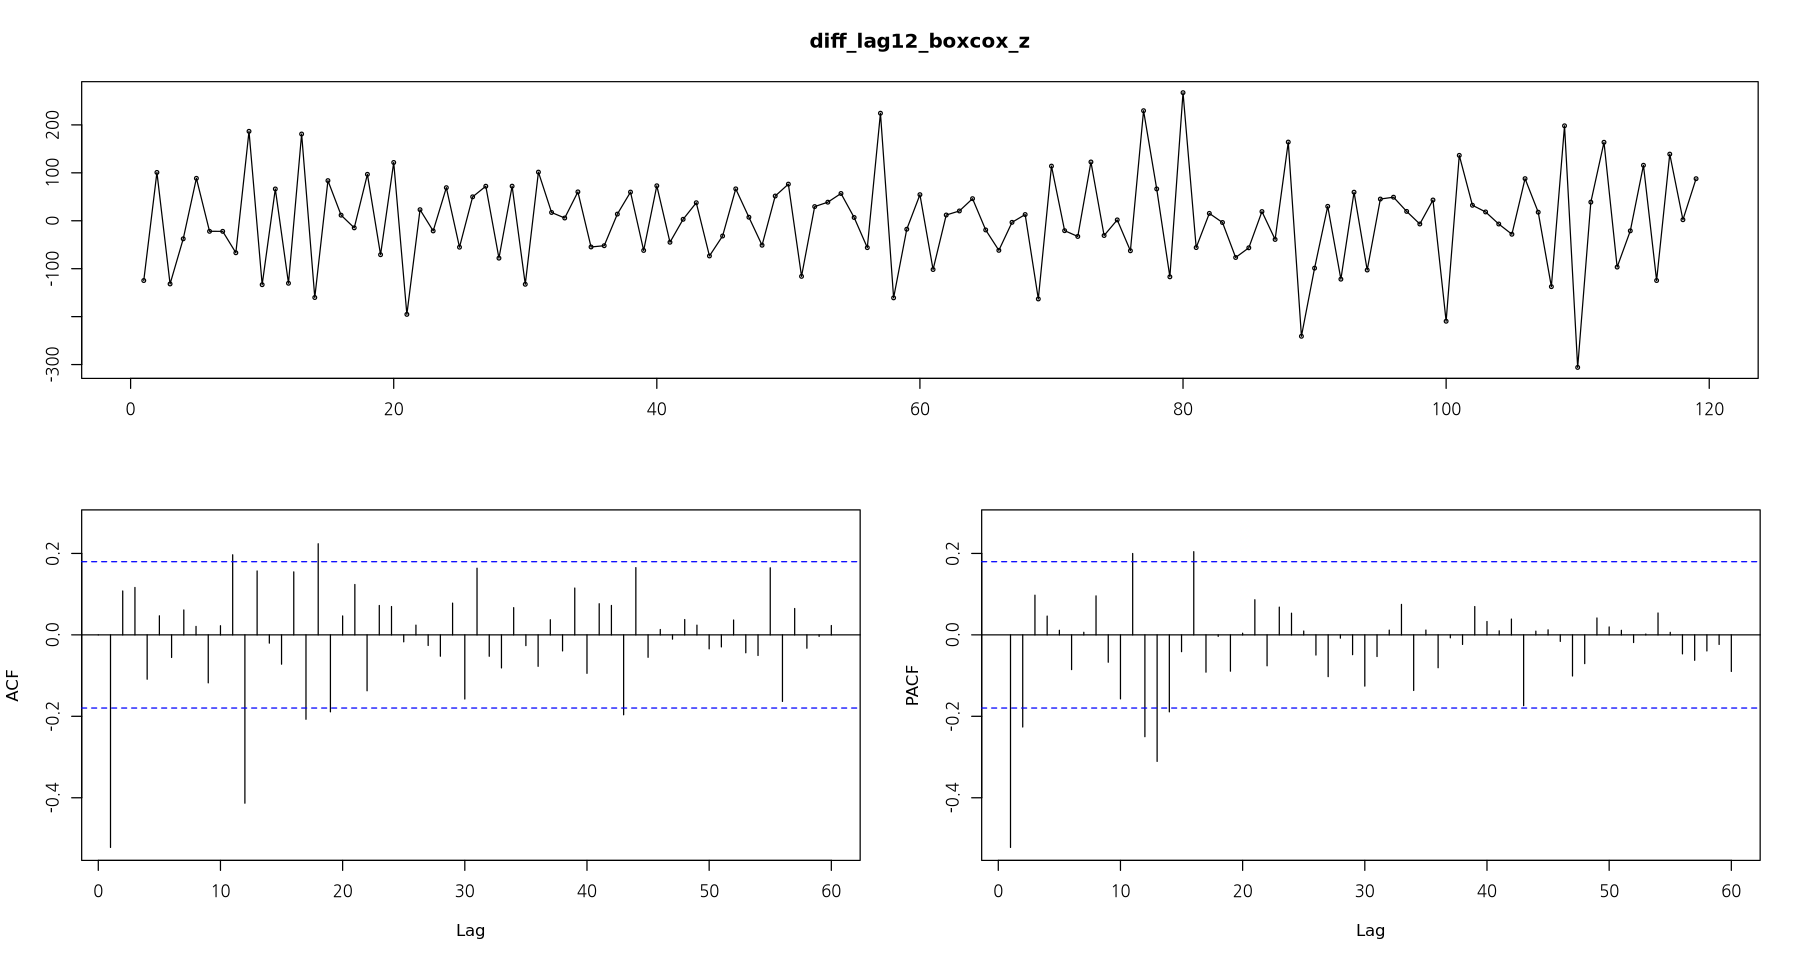

In [12]:
diff_lag12_boxcox_z = diff(lag12_boxcox_z)
forecast::tsdisplay(diff_lag12_boxcox_z, lag.max=60)

* 혹시 확률적 추세가 더 있나?

In [13]:
## 단위근검정 H0 : phi=1
fUnitRoots::adfTest(diff_lag12_boxcox_z, lags = 1, type = "nc")

Warning message in fUnitRoots::adfTest(diff_lag12_boxcox_z, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -11.7961
  P VALUE:
    0.01 

Description:
 Wed Nov 27 18:03:31 2024 by user: 

> 단위근은 존재하지 않는다 -> 확률적 추세는 없다 -> 추가적 차분은 시행하지 않는다.

`-` 모형 식별

In [14]:
t.test(diff_lag12_boxcox_z)


	One Sample t-test

data:  diff_lag12_boxcox_z
t = 0.11301, df = 118, p-value = 0.9102
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -16.93470  18.98455
sample estimates:
mean of x 
 1.024925 


> 혹시나 평균 term을 추가해야 할지를 봐야 함.

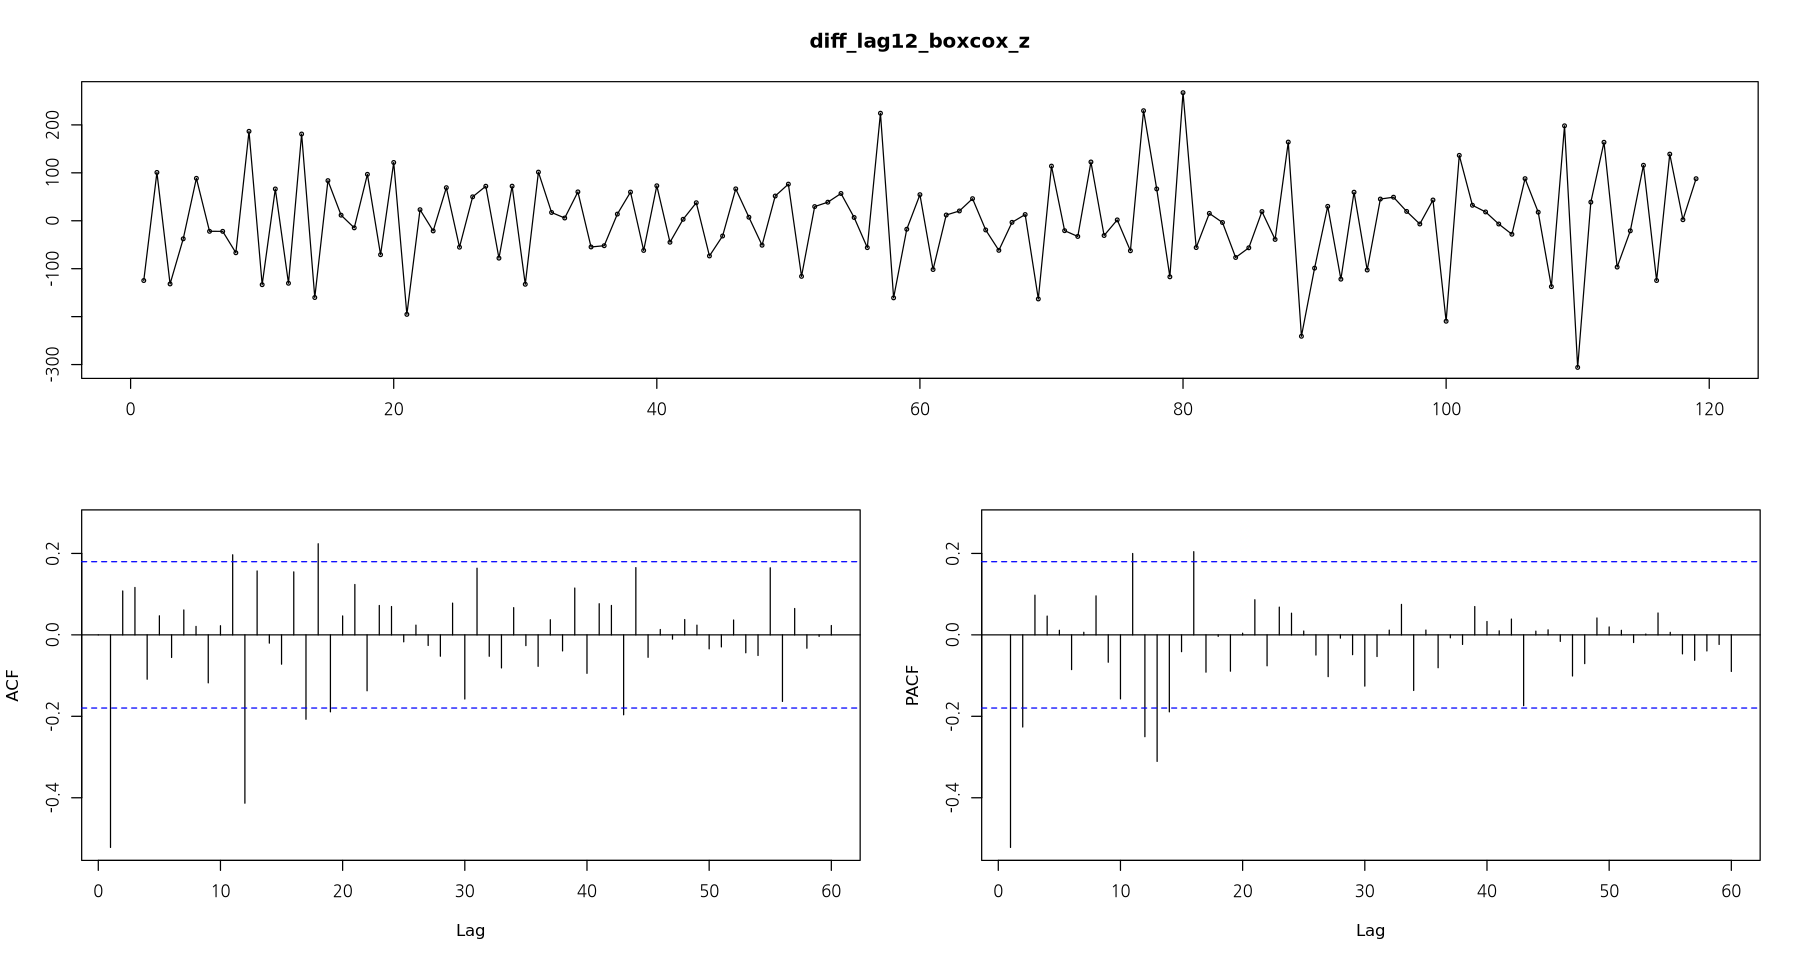

In [16]:
forecast::tsdisplay(diff_lag12_boxcox_z, lag.max = 60)

> ACF는 1, 12시차만 유의 -> MA(1)이거나 계절형 MA(1)모형
>
> PACF는 2시차까지 유의 / 12,13시차 유의 -> AR(2) / 계절형 AR(1)
>
> 모형의 단순성을 고려하여 MA(1), 계절형 MA(1) / 계절형 AR(1)을 적합할 수 있음.

* `diff_lag12_boxcox_z` $= ARIMA(0,0,1)(0,0,1)_{12}$ : 차분 이미 다 했음
* `lag12_boxcox_z` $= ARIMA(0,1,1)(0,0,1)_{12}$ : 계절차분만 했음
* `boxcox_z` $= ARIMA(0,1,1)(0,1,1)_{12}$ : 차분 하나도 안함

`-` 모형 적합

In [17]:
#상수항 추가 여부
t.test(diff_lag12_boxcox_z)


	One Sample t-test

data:  diff_lag12_boxcox_z
t = 0.11301, df = 118, p-value = 0.9102
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -16.93470  18.98455
sample estimates:
mean of x 
 1.024925 


> 상수항 추가 안함

`-` 변수변환만 한 걸로 하는 게 가장 편함 : $ARIMA(0,1,1)(0,1,1)_{12}$

In [18]:
fit1 = arima(boxcox_z, order = c(0,1,1), seasonal = list(order = c(0,1,1), period=12))
fit1


Call:
arima(x = boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

In [21]:
## 차분을 다 한 모형 -> 평균 포함 여부 기재
fit2 = arima(diff_lag12_boxcox_z, order = c(0,0,1), include.mean = F,
             seasonal = list(order = c(0,0,1), period = 12))

## 차분을 한번이라도 하는 모형 -> 평균 알아서 뺄지 결정
fit3 = arima(lag12_boxcox_z, order = c(0,1,1),
             seasonal = list(order = c(0,0,1), period = 12))

In [22]:
fit2
fit3


Call:
arima(x = diff_lag12_boxcox_z, order = c(0, 0, 1), seasonal = list(order = c(0, 
    0, 1), period = 12), include.mean = F)

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74


Call:
arima(x = lag12_boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 
    1), period = 12))

Coefficients:
          ma1     sma1
      -0.5307  -0.6370
s.e.   0.0702   0.0842

sigma^2 estimated as 4831:  log likelihood = -676.87,  aic = 1359.74

> 올바르게 적으면 다 동일하게 나옴 ㅇㅇ

`-` 계수 검정

In [23]:
lmtest::coeftest(fit1)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.530740   0.070154 -7.5654 3.868e-14 ***
sma1 -0.637038   0.084175 -7.5680 3.790e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


`-` 적합된 모형(? prediction이라는 기호를 어디에 넣어야 되나...?)

$(1-B)(1-B^{12})\text{BoxCox}(Z) = (1-0.5307B)(1-0.6370B^{12})\varepsilon_t ~ \varepsilon_t \sim WN(0, 4831)$

`-` 잔차 분석


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,1)[12]
Q* = 9.1519, df = 8, p-value = 0.3296

Model df: 2.   Total lags used: 10



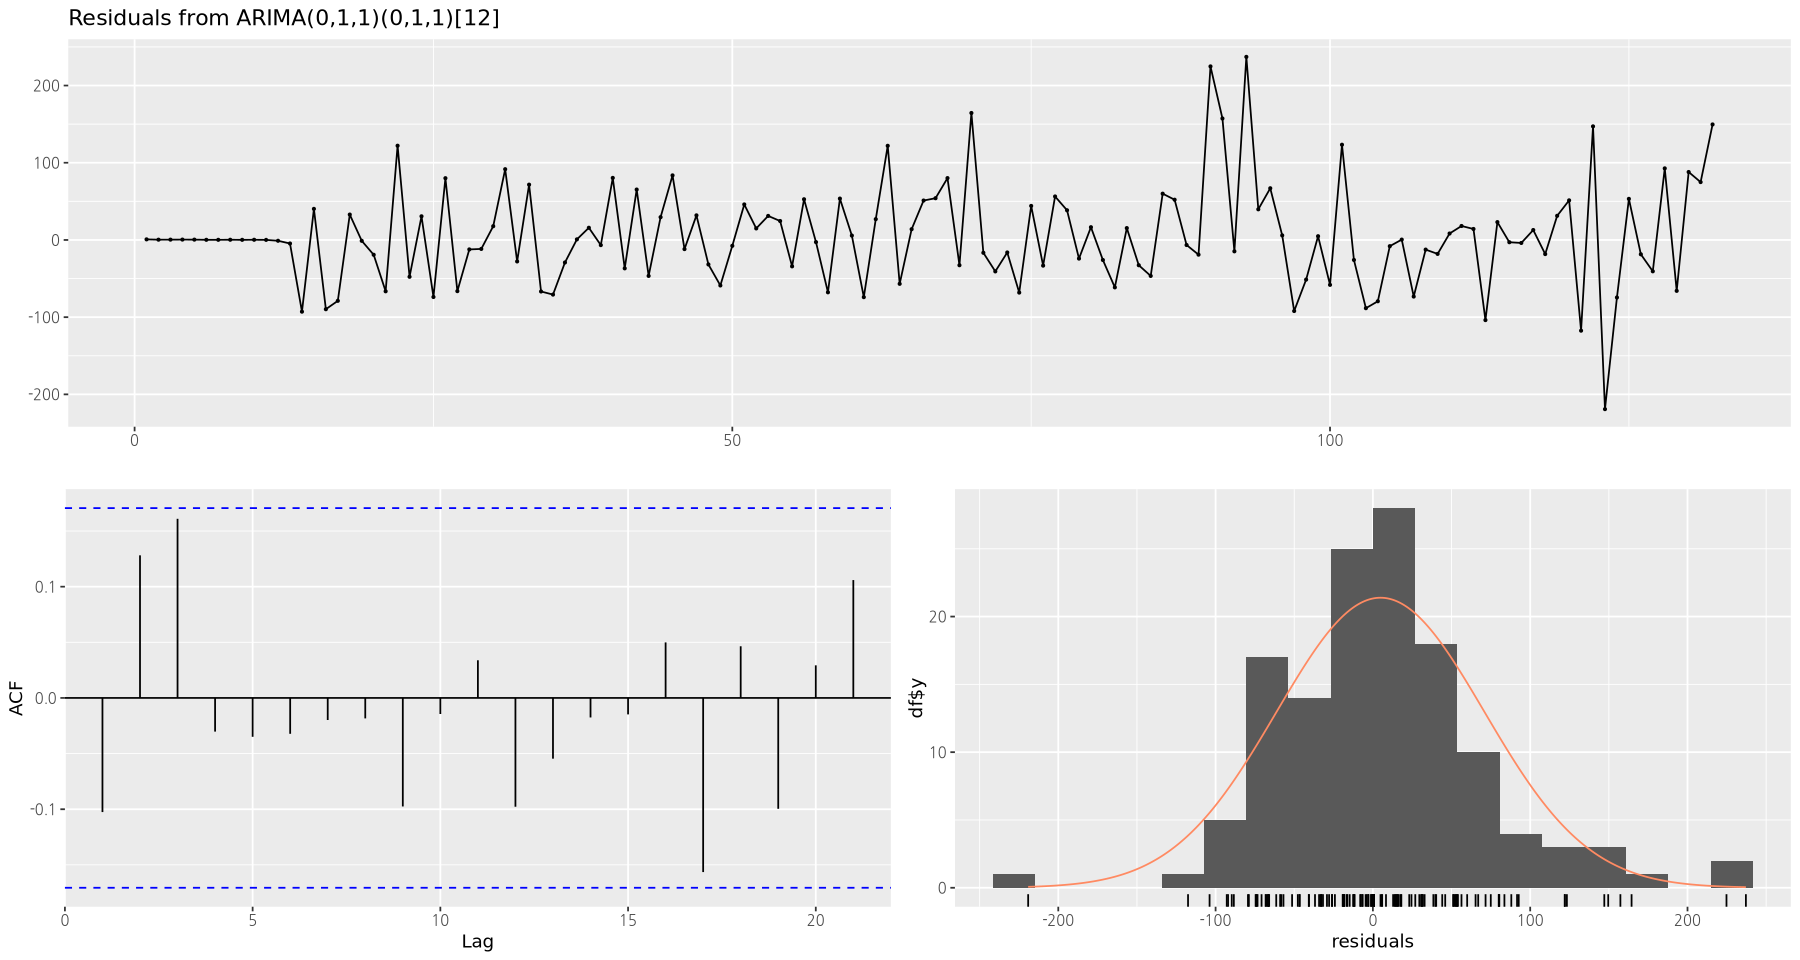

In [24]:
forecast::checkresiduals(fit1)

In [25]:
t.test(resid(fit1))


	One Sample t-test

data:  resid(fit1)
t = 0.83993, df = 131, p-value = 0.4025
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -6.546096 16.206445
sample estimates:
mean of x 
 4.830174 


> 등분산성을 만족하고, ACF가 모든 시차에서 유의하지 않으므로 WN이다

In [26]:
# 잔차의 포트맨토 검정 ## H0 : rho1=...=rho_k=0
portes::LjungBox(fit1, lags=c(6,12,18,24))

,lags,statistic,df,p-value
,6,7.650531,5,0.1765764
,12,10.728871,11,0.4662493
,18,15.730829,17,0.5429906
,24,25.724146,23,0.3140605


> 모든 시차에 대해 유의확률이 크기 때문에 WN이다.

`-` 과대적합

In [27]:
fit2 = arima(boxcox_z, order = c(1,1,1), seasonal = list(order = c(0,1,1), period=12))
fit2


Call:
arima(x = boxcox_z, order = c(1, 1, 1), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ar1      ma1     sma1
      -0.3345  -0.2984  -0.6183
s.e.   0.1354   0.1299   0.0828

sigma^2 estimated as 4658:  log likelihood = -674.51,  aic = 1357.01

In [28]:
fit3 = arima(boxcox_z, order = c(0,1,2), seasonal = list(order = c(0,1,1), period=12))
fit3


Call:
arima(x = boxcox_z, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 1), 
    period = 12))

Coefficients:
          ma1     ma2     sma1
      -0.6445  0.2825  -0.6236
s.e.   0.0871  0.1009   0.0833

sigma^2 estimated as 4569:  log likelihood = -673.44,  aic = 1354.88

In [29]:
fit4 = arima(boxcox_z, order = c(0,1,1), seasonal = list(order = c(1,1,0), period=12))
fit4


Call:
arima(x = boxcox_z, order = c(0, 1, 1), seasonal = list(order = c(1, 1, 0), 
    period = 12))

Coefficients:
          ma1     sar1
      -0.5583  -0.5525
s.e.   0.0670   0.0804

sigma^2 estimated as 5011:  log likelihood = -678.13,  aic = 1362.25

In [30]:
fit1$aic
fit2$aic
fit3$aic
fit4$aic

[1] 1359.744

[1] 1357.01

[1] 1354.88

[1] 1362.255

In [31]:
fit1$sigma2
fit2$sigma2
fit3$sigma2
fit4$sigma2

[1] 4831.203

[1] 4658.259

[1] 4568.524

[1] 5010.744

> AIC는 MA(2)까지 했을 때 가장 적었음. 그래도 나는 모형을 제일 간단한 걸 쓰고 싶다! -> 그냥 기존 ARIMA(0,1,1)(0,1,1)_{12}쓰면 됨

`-` $ARIMA(0,1,2)(0,1,1)_{12}$를 최종 모형으로 선택


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2)(0,1,1)[12]
Q* = 3.3401, df = 7, p-value = 0.8519

Model df: 3.   Total lags used: 10



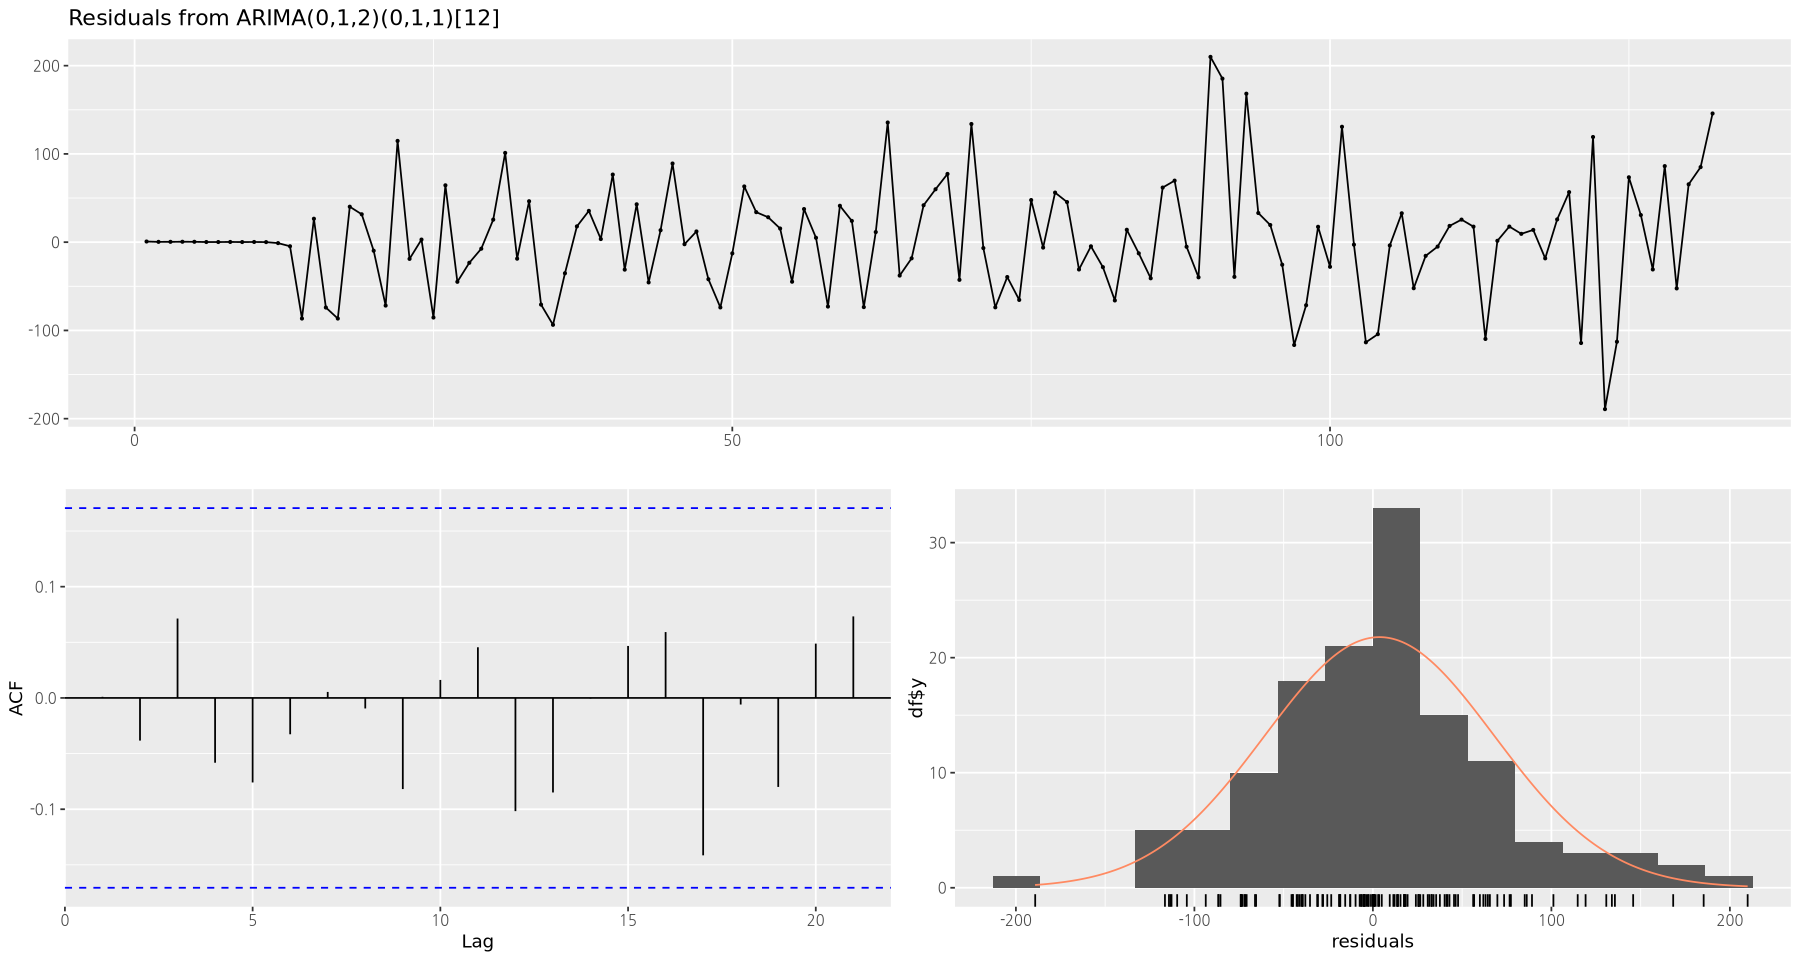

In [32]:
forecast::checkresiduals(fit3)

In [33]:
# 잔차의 포트맨토 검정 ## H0 : rho1=...=rho_k=0
portes::LjungBox(fit3, lags=c(6,12,18,24))

,lags,statistic,df,p-value
,6,2.320573,4,0.6770260
,12,5.167375,10,0.8797203
,18,10.187027,16,0.8566804
,24,18.983268,22,0.6463614


> 잔차 검정 결과도 이상이 없으므로 fit3를 최종모형으로 선택

`-` `auto.arima`

In [34]:
forecast::auto.arima(ts(boxcox_z, frequency=12),
                     test = "adf",
                     seasonal = TRUE, trace = T)


 ARIMA(2,1,2)(1,1,1)[12]                    : 1357.774
 ARIMA(0,1,0)(0,1,0)[12]                    : 1432.23
 ARIMA(1,1,0)(1,1,0)[12]                    : 1360.54
 ARIMA(0,1,1)(0,1,1)[12]                    : 1359.953
 ARIMA(2,1,2)(0,1,1)[12]                    : 1358.211
 ARIMA(2,1,2)(1,1,0)[12]                    : 1359.268
 ARIMA(2,1,2)(2,1,1)[12]                    : 1359.649
 ARIMA(2,1,2)(1,1,2)[12]                    : 1358.941
 ARIMA(2,1,2)(0,1,0)[12]                    : 1394.751
 ARIMA(2,1,2)(0,1,2)[12]                    : 1358.288
 ARIMA(2,1,2)(2,1,0)[12]                    : 1359.606
 ARIMA(2,1,2)(2,1,2)[12]                    : 1361.251
 ARIMA(1,1,2)(1,1,1)[12]                    : 1356.533
 ARIMA(1,1,2)(0,1,1)[12]                    : 1357.41
 ARIMA(1,1,2)(1,1,0)[12]                    : 1357.649
 ARIMA(1,1,2)(2,1,1)[12]                    : Inf
 ARIMA(1,1,2)(1,1,2)[12]                    : Inf
 ARIMA(1,1,2)(0,1,0)[12]                    : 1393.906
 ARIMA(1,1,2)(0,1,2)[1

Series: ts(boxcox_z, frequency = 12) 
ARIMA(0,1,2)(1,1,1)[12] 

Coefficients:
          ma1     ma2     sar1     sma1
      -0.6662  0.2996  -0.3012  -0.4028
s.e.   0.0880  0.0997   0.1645   0.1751

sigma^2 = 4601:  log likelihood = -671.9
AIC=1353.79   AICc=1354.32   BIC=1367.69

> 얘를 최종 모형으로 쓸 수도 있긴 함.

In [35]:
fit5 <- forecast::auto.arima(ts(boxcox_z, frequency=12),
                             test = "adf",
                             seasonal = TRUE)

In [36]:
lmtest::coeftest(fit5)


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1  -0.666226   0.088010 -7.5699 3.734e-14 ***
ma2   0.299594   0.099683  3.0055  0.002652 ** 
sar1 -0.301227   0.164489 -1.8313  0.067058 .  
sma1 -0.402808   0.175098 -2.3005  0.021421 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [37]:
fit3$aic
fit5$aic


[1] 1354.88

[1] 1353.793

> 최종선택 모형에 비해 AIC나 분산이 조금 작아졌으나 추가된 계수가 유의하지 않으므로 기존 모형을 유지한다.

`-` forecasting

In [38]:
fore_fit <- forecast::forecast(fit3, 24)
fore_fit

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
133       2780.444 2693.821 2867.067 2647.966 2912.923
134       2948.470 2856.536 3040.404 2807.869 3089.071
135       3133.218 3025.951 3240.484 2969.168 3297.267
136       3219.609 3098.943 3340.275 3035.067 3404.151
137       3304.710 3171.991 3437.429 3101.734 3507.686
138       3299.345 3155.579 3443.110 3079.474 3519.215
139       3256.562 3102.541 3410.584 3021.007 3492.118
140       3385.280 3221.644 3548.916 3135.020 3635.540
141       3349.803 3177.087 3522.520 3085.657 3613.950
142       3514.000 3332.658 3695.342 3236.661 3791.339
143       3340.552 3150.976 3530.129 3050.621 3630.484
144       3151.776 2954.309 3349.243 2849.776 3453.776
145       3024.749 2808.612 3240.886 2694.196 3355.302
146       3167.091 2940.850 3393.332 2821.085 3513.096
147       3351.838 3113.152 3590.525 2986.799 3716.878
148       3438.230 3187.715 3688.744 3055.101 3821.358
149       3523.330 3261.522 3785.139 3122.929 3923.732
150       

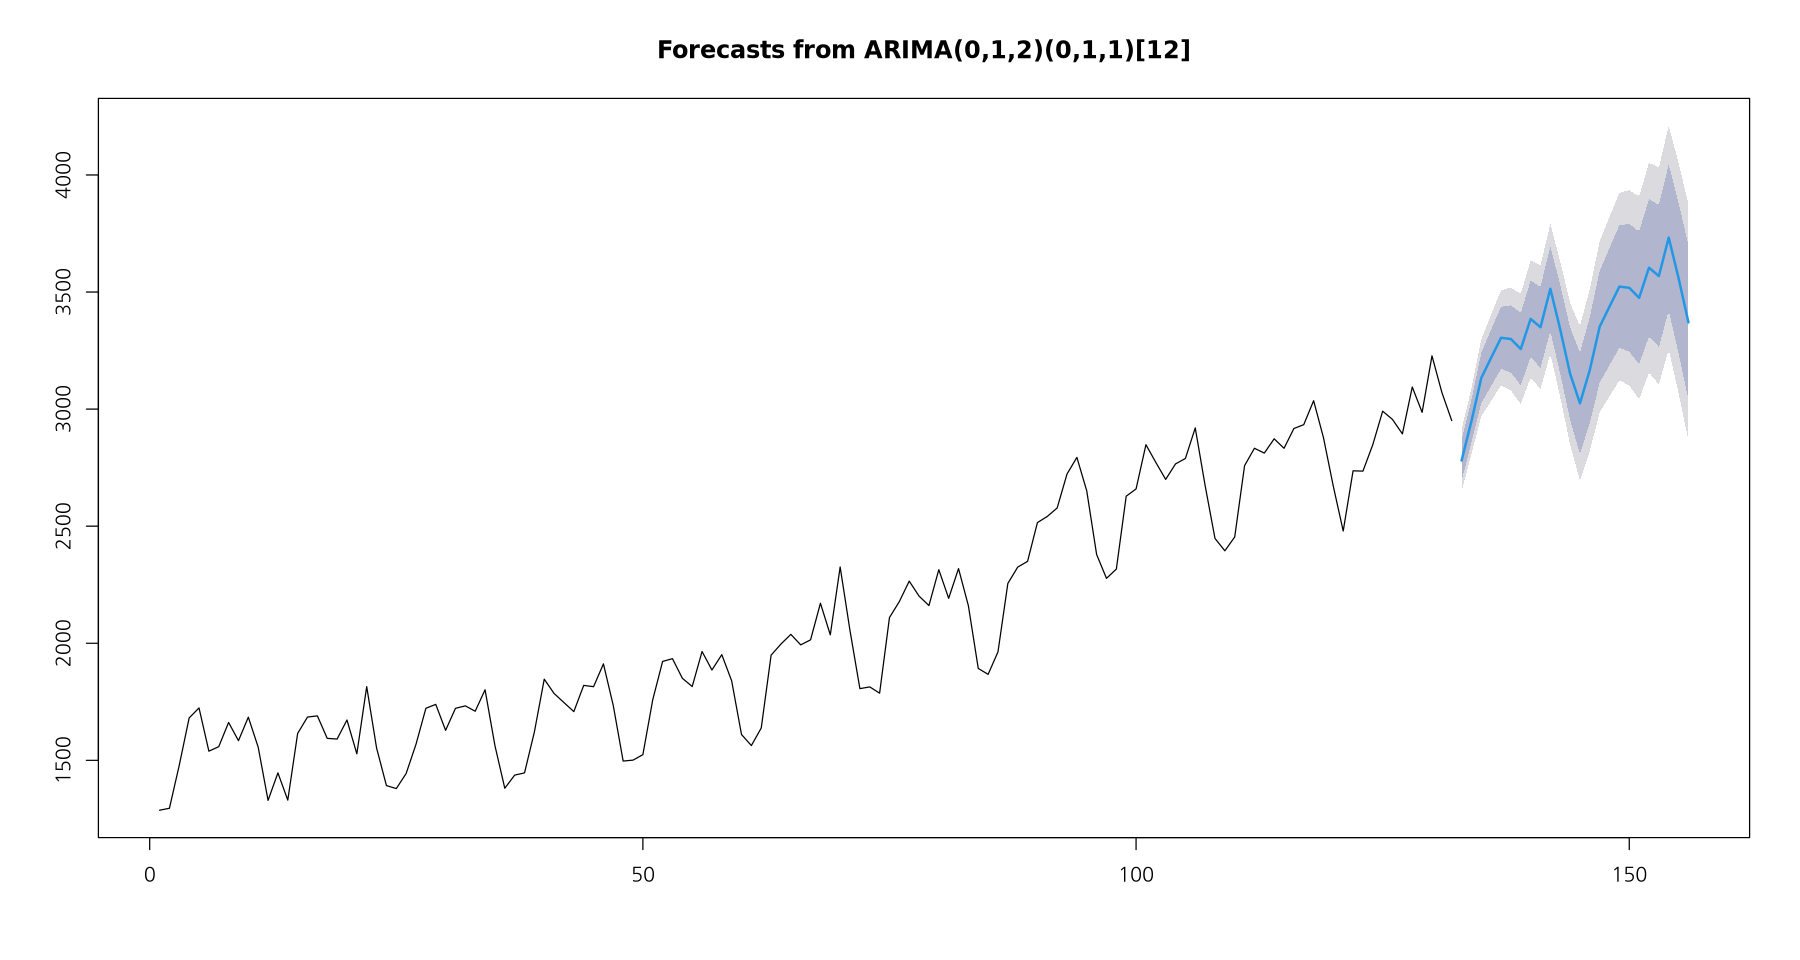

In [39]:
plot(fore_fit)

**여기서 끝이 아니다!**

### 역변환

point estimate를 가져다가 lambda를 먹여서 역변환

In [40]:
forecast_z = forecast::InvBoxCox(fore_fit$mean, lambda = forecast::BoxCox.lambda(z))
forecast_z

A Time Series:
 [1] 245634.2 270964.3 299958.6 313921.3 327924.4 327034.3 319971.6 341407.6
 [9] 335443.8 363400.0 333895.6 302936.5 282791.7 305402.8 335784.7 350387.4
[17] 365015.5 364086.2 356709.7 379086.0 372864.1 402007.3 371248.5 338900.5

> 실제로 추정된 값임. ㅇㅇ

In [41]:
forecast_z_upper95 = forecast::InvBoxCox(fore_fit$upper[,2], lambda=forecast::BoxCox.lambda(z))
forecast_z_lower95 = forecast::InvBoxCox(fore_fit$lower[,2], lambda=forecast::BoxCox.lambda(z))

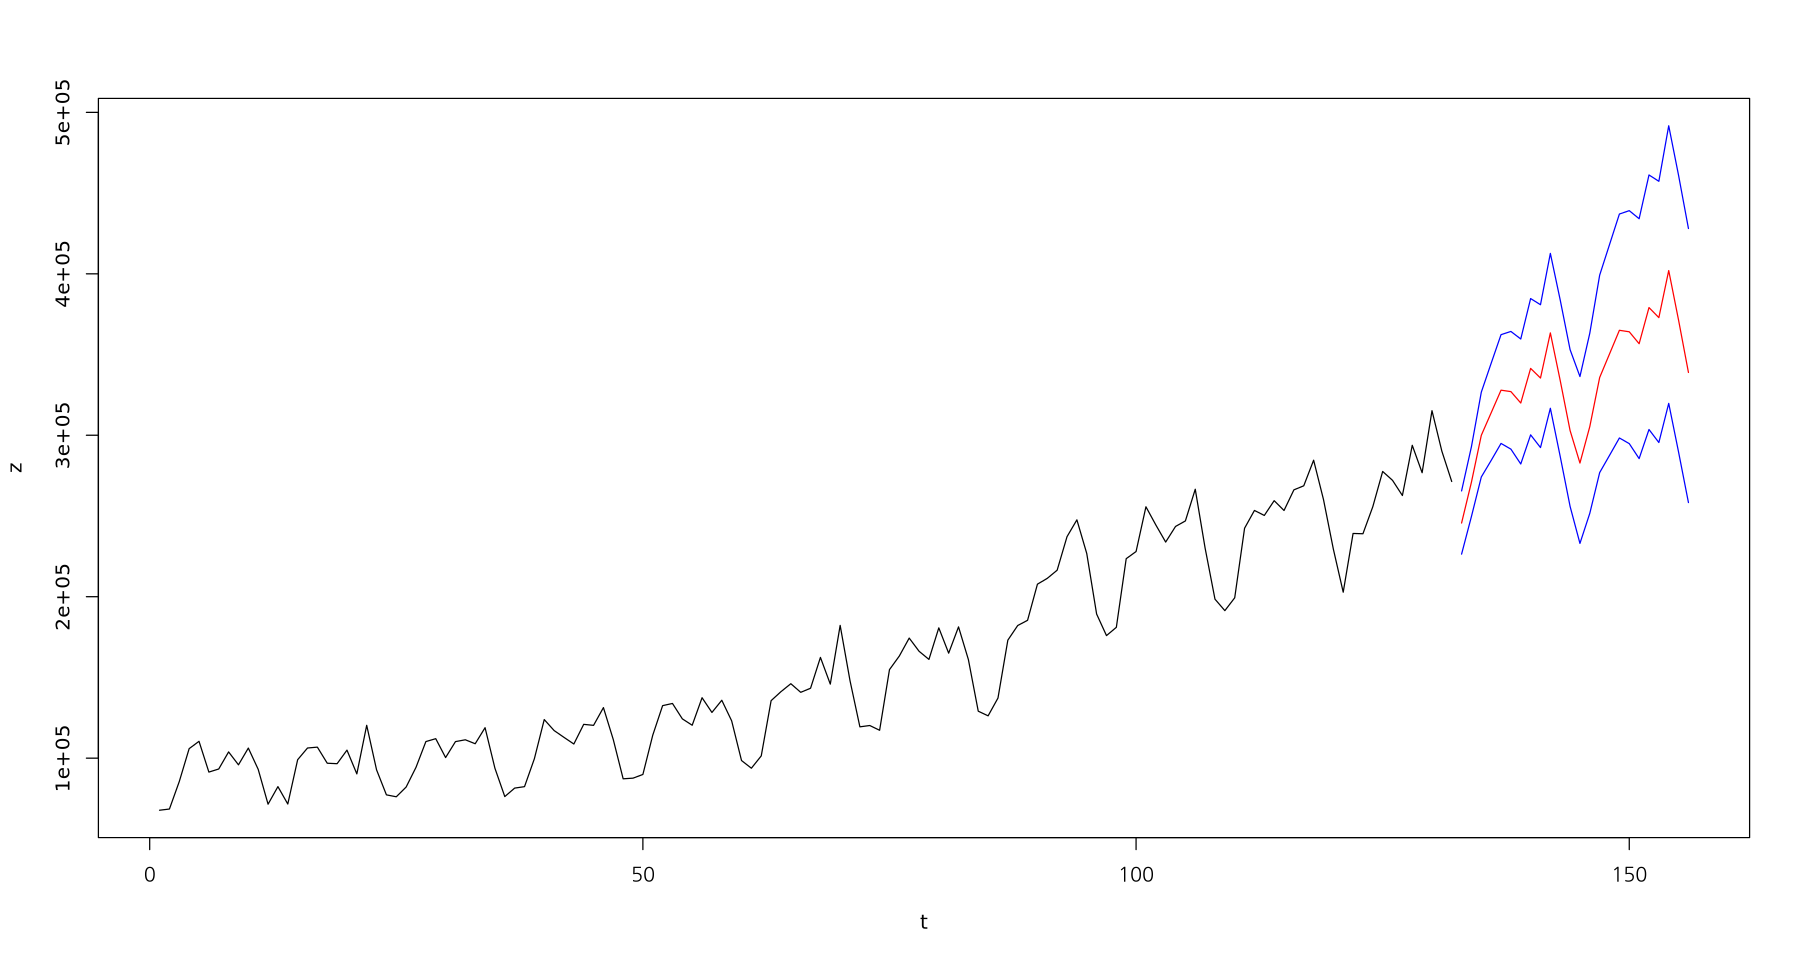

In [42]:
plot(1:(length(z)+24), c(z, forecast_z_upper95), type='n', xlab='t', ylab='z')
lines(1:length(z),z)
lines((length(z)+1) : (length(z)+24), forecast_z, col='red')
lines((length(z)+1) : (length(z)+24), forecast::InvBoxCox(fore_fit$lower[,2], lambda=forecast::BoxCox.lambda(z)), col = "blue")
lines((length(z)+1) : (length(z)+24), forecast::InvBoxCox(fore_fit$upper[,2], lambda=forecast::BoxCox.lambda(z)), col = "blue")

## Simulation

In [ ]:
# astsa::sarima.sim(ar = NULL, d = 0, ma = NULL, sar = NULL, D = 0, sma = NULL, S = NULL,
#                     n = 500, rand.gen = rnorm, innov = NULL, burnin = NA, t0 = 0, ...)

# sarima::sim_sarima(model=list(ar,iorder,ma, sar, siorder, sma, nseasons, sigma2),
#                     n = NA, rand.gen = rnorm, n.start = NA, x, eps,
#                     xcenter = NULL, xintercept = NULL, ...)

In [ ]:
### ARIMA(p,d,q)(P,D,Q)_s
x <- sarima::sim_sarima(n=200, n.start=12,
                        model=list(ar = 0.7, siorder=1, nseasons=12, sigma2 = 1)) # SMA(1)
forecast::tsdisplay(x, lag.max=60)

In [ ]:
x <- astsa::sarima.sim(ar = 0.5, d = 1, ma = 0.1, sar = 0.1, D = 1, sma = 0, S = 12, n = 100)
forecast::tsdisplay(x)

> ㅁ